In [1]:
# warning: pdfminer uses python 2
from __future__ import division

The UK government regularly releases information about the meetings that various ministers have with external organisations. You can find the releases by searching [here](https://www.gov.uk/government/publications). The hope is that by releasing information like this the public, journalists and other organisations can have some level of scrutiny over who members of parliament are meeting.

Unfortunately, the information is released in a number of different formats and styles, making any sort of attempt to automatically catalogue it difficult. On the suggestion of [Transparency International](http://www.transparency.org.uk/), I have been attempting to automate the procedure. If you are interested in the output dataset, you can find it [here](https://github.com/ijmbarr/uk_minister_meetings), the full code I used to parse the documents can be found [here](https://github.com/ijmbarr/ti_intergrity_watch), (warning: it is a mess, currently undocumented and still in progress). 

To produce the output, I had to extract tabular information from a number of different formats: .csv, .doc, .pdf, .xlsx, .odt and .opd. Of these, by far the most difficult was the PDF file. While there are a number of different tools for extracting tabular information from pdf documents, such as [tabula](https://www.gov.uk/government/publications) and [pdftables](https://pdftables.readthedocs.io/en/latest/), neither of them quite worked on the documents I was looking at, so I decided to create my own.

Reading around, you find the the best advice about parsing PDFs is [don't do it unless you have to](https://www.binpress.com/tutorial/manipulating-pdfs-with-python/167). The reason is, as we will see, unlike formats like html or other markup languages where tables and their internal structure are well defined, in PDFs we only have low level information about the location of individual characters and lines on the page. We are going to have to use this information to infer how the table is structured.

The results presented here aren't that polished yet, and I don't know how readily they will apply to other pdf formats. However, I hope this method might be of some use to other.

## The Problem

An example of the document we would like to parse can be found [here](https://www.gov.uk/government/publications/hmt-ministers-meetings-hospitality-gifts-and-overseas-travel-1-april-to-30-june-2014), [here](https://www.gov.uk/government/uploads/system/uploads/attachment_data/file/362728/Ministerial_Quarterly_Transparency_information_-_January_to_March_2014.pdf) and [here](https://www.gov.uk/government/publications/department-of-culture-media-and-sport-ministerial-gifts-hospitality-travel-and-meetings-july-2014-to-march-2015). Let start with the first one as an example. In order to access the content of the PDFs, I'm going to use [pdfminer](http://euske.github.io/pdfminer/index.html). 

The first job is to find out what sort of object exist within the PDF. pdfminer return a list of LTPage objects describing each page. Each page can contain other objects: text, rectangles, lines figures, etc. (the full hierarchy of objects returned by pdfminer is detailed [here](https://euske.github.io/pdfminer/programming.html#layout)). We can pull out pages of the document using the following code:

In [2]:
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfpage import PDFTextExtractionNotAllowed
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.layout import LAParams
from pdfminer.converter import PDFPageAggregator


def extract_layout_by_page(pdf_path):
    """
    Extracts LTPage objects from a pdf file.
    
    slightly modified from
    https://euske.github.io/pdfminer/programming.html
    """
    laparams = LAParams()

    fp = open(pdf_path, 'rb')
    parser = PDFParser(fp)
    document = PDFDocument(parser)

    if not document.is_extractable:
        raise PDFTextExtractionNotAllowed

    rsrcmgr = PDFResourceManager()
    device = PDFPageAggregator(rsrcmgr, laparams=laparams)
    interpreter = PDFPageInterpreter(rsrcmgr, device)

    layouts = []
    for page in PDFPage.create_pages(document):
        interpreter.process_page(page)
        layouts.append(device.get_result())

    return layouts

example_file = "data/DH_Ministerial_gifts_hospitality_travel_and_external_meetings_Jan_to_Mar_2015.pdf"
page_layouts = extract_layout_by_page(example_file)

In [3]:
len(page_layouts)

12

We can now ask what are the types of object in the documents:

In [3]:
objects_on_page = set(type(o) for o in page_layouts[3])
objects_on_page

{pdfminer.layout.LTRect, pdfminer.layout.LTTextBoxHorizontal}

So it looks like we are only dealing with text, or rectangles. The text exists as text boxes, unfortunately they don't always match up with the table columns in a way we would like, so recursively extract each character from the text objects:

In [4]:
import pdfminer

TEXT_ELEMENTS = [
    pdfminer.layout.LTTextBox,
    pdfminer.layout.LTTextBoxHorizontal,
    pdfminer.layout.LTTextLine,
    pdfminer.layout.LTTextLineHorizontal
]

def flatten(lst):
    """Flattens a list of lists"""
    return [subelem for elem in lst for subelem in elem]


def extract_characters(element):
    """
    Recursively extracts individual characters from 
    text elements. 
    """
    if isinstance(element, pdfminer.layout.LTChar):
        return [element]

    if any(isinstance(element, i) for i in TEXT_ELEMENTS):
        return flatten([extract_characters(e) for e in element])

    if isinstance(element, list):
        return flatten([extract_characters(l) for l in element])

    return []

In [5]:
current_page = page_layouts[4]

texts = []
rects = []

# separate text and rectangle elements
for e in current_page:
    if isinstance(e, pdfminer.layout.LTTextBoxHorizontal):
        texts.append(e)
    elif isinstance(e, pdfminer.layout.LTRect):
        rects.append(e)

# sort them into 
characters = extract_characters(texts)

Each element of the pdf is described the the bounding box. We can use this to visualise how the page is arranged:

In [6]:
import matplotlib.pyplot as plt
from matplotlib import patches
%matplotlib inline

   
def draw_rect_bbox((x0,y0,x1,y1), ax, color):
    """
    Draws an unfilled rectable onto ax.
    """
    ax.add_patch( 
        patches.Rectangle(
            (x0, y0),
            x1 - x0,
            y1 - y0,
            fill=False,
            color=color
        )    
    )
    
def draw_rect(rect, ax, color="black"):
    draw_rect_bbox(rect.bbox, ax, color)

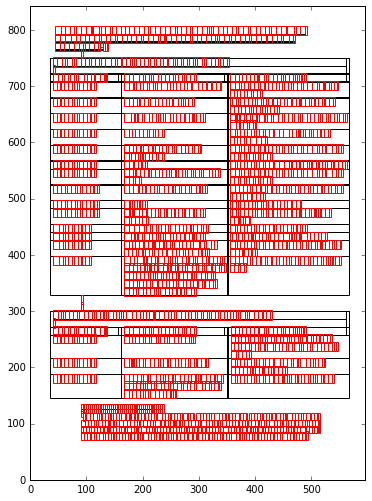

In [7]:
xmin, ymin, xmax, ymax = current_page.bbox
size = 6

fig, ax = plt.subplots(figsize = (size, size * (ymax/xmax)))

for rect in rects:
    draw_rect(rect, ax)
    
for c in characters:
    draw_rect(c, ax, "red")
    

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

To pull out the information in table format, we need a way to identify the cells of the table, and to identify which cell each character belongs to.

It would be nice to think that the rectangles here match the edges of the cells of the tables, however exploring the layout you find that while some rectangles refer to cells, other seem to be used as line segments, and others as pixels. Some investigation suggest that the table can be defined by only looking at the rectangle which are "line-like", which we defined as any rectangle narrower then two pixels, with an area greater than one pixel:

In [8]:
def width(rect):
    x0, y0, x1, y1 = rect.bbox
    return min(x1 - x0, y1 - y0)

def area(rect):
    x0, y0, x1, y1 = rect.bbox
    return (x1 - x0) * (y1 - y0)


def cast_as_line(rect):
    """
    Replaces a retangle with a line based on its longest dimension.
    """
    x0, y0, x1, y1 = rect.bbox

    if x1 - x0 > y1 - y0:
        return (x0, y0, x1, y0, "H")
    else:
        return (x0, y0, x0, y1, "V")
    
lines = [cast_as_line(r) for r in rects
         if width(r) < 2 and
         area(r) > 1]

Plotting the page again, but only with the lines gives:

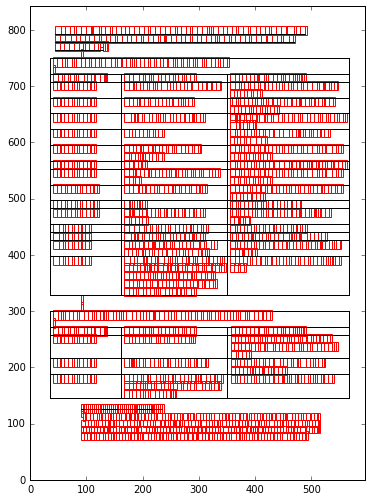

In [9]:
xmin, ymin, xmax, ymax = current_page.bbox
size = 6

fig, ax = plt.subplots(figsize = (size, size * (ymax/xmax)))

for l in lines:
    x0,y0,x1,y1,_ = l
    plt.plot([x0, x1], [y0, y1], 'k-')
    
for c in characters:
    draw_rect(c, ax, "red")

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

Now onto the main question: how do we assign characters to cells? We use a simple idea, for each character, find the line that bounds it from above, below, left and right. Define these four lines as the cell. We do this using the following function

In [10]:
def does_it_intersect(x, (xmin, xmax)):
    return (x <= xmax and x >= xmin)

def find_bounding_rectangle((x, y), lines):
    """
    Given a collection of lines, and a point, try to find the rectangle 
    made from the lines that bounds the point. If the point is not 
    bounded, return None.
    """
    
    v_intersects = [l for l in lines
                    if l[4] == "V"
                    and does_it_intersect(y, (l[1], l[3]))]

    h_intersects = [l for l in lines
                    if l[4] == "H"
                    and does_it_intersect(x, (l[0], l[2]))]

    if len(v_intersects) < 2 or len(h_intersects) < 2:
        return None

    v_left = [v[0] for v in v_intersects
              if v[0] < x]

    v_right = [v[0] for v in v_intersects
               if v[0] > x]

    if len(v_left) == 0 or len(v_right) == 0:
        return None

    x0, x1 = max(v_left), min(v_right)

    h_down = [h[1] for h in h_intersects
              if h[1] < y]

    h_up = [h[1] for h in h_intersects
            if h[1] > y]

    if len(h_down) == 0 or len(h_up) == 0:
        return None

    y0, y1 = max(h_down), min(h_up)

    return (x0, y0, x1, y1)

The line segments that make up the cell boundaries aren't always complete - those small pixel sized rectangle we threw away earlier leave gaps in them. Combined with the bbox's of character sometime lying outside their cell, we have to be careful about which point we use to find its cell. To make things robust I use three points: the bottom left corner, the top right corner and the centre. The box that defines that majority of these is the one chosen.

We can now run this code over every character. 

In [11]:
from collections import defaultdict
import math

box_char_dict = {}

for c in characters:
    # choose the bounding box that occurs the majority of times for each of these:
    bboxes = defaultdict(int)
    l_x, l_y = c.bbox[0], c.bbox[1]
    bbox_l = find_bounding_rectangle((l_x, l_y), lines)
    bboxes[bbox_l] += 1

    c_x, c_y = math.floor((c.bbox[0] + c.bbox[2]) / 2), math.floor((c.bbox[1] + c.bbox[3]) / 2)
    bbox_c = find_bounding_rectangle((c_x, c_y), lines)
    bboxes[bbox_c] += 1

    u_x, u_y = c.bbox[2], c.bbox[3]
    bbox_u = find_bounding_rectangle((u_x, u_y), lines)
    bboxes[bbox_u] += 1

    # if all values are in different boxes, default to character center.
    # otherwise choose the majority.
    if max(bboxes.values()) == 1:
        bbox = bbox_c
    else:
        bbox = max(bboxes.items(), key=lambda x: x[1])[0]

    if bbox is None:
        continue

    if bbox in box_char_dict.keys():
        box_char_dict[bbox].append(c)
        continue

    box_char_dict[bbox] = [c]

To check that this has works, we can plot the page again, focusing on one particular cell:

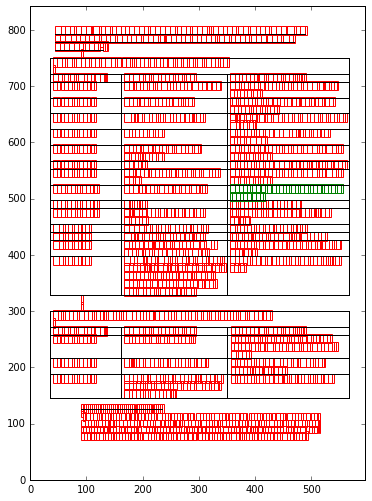

In [12]:
import random
xmin, ymin, xmax, ymax = current_page.bbox
size = 6

fig, ax = plt.subplots(figsize = (size, size * (ymax/xmax)))

for l in lines:
    x0,y0,x1,y1,_ = l
    plt.plot([x0, x1], [y0, y1], 'k-')
    
for c in characters:
    draw_rect(c, ax, "red")
    
# plot the characters of a random cell as green
for c in random.choice(box_char_dict.values()): 
    draw_rect(c, ax, "green")

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

To capture empty cells, I choose a grid on points across the page and try to assign them to a cell. If this cell isn't present in box_char_dict, then it is created and left empty.

In [13]:
xmin, ymin, xmax, ymax = current_page.bbox

for x in range(int(xmin), int(xmax), 10):
    for y in range(int(ymin), int(ymax), 10):
        bbox = find_bounding_rectangle((x, y), lines)

        if bbox is None:
            continue

        if bbox in box_char_dict.keys():
            continue

        box_char_dict[bbox] = []

All that remains is to map between the ordering of cells on the page and a python data structure and between the ordering of characters in a cell and a string. The two functions below carry this out:

In [14]:
def chars_to_string(chars):
    """
    Converts a collection of characters into a string, by ordering them left to right, 
    then top to bottom.
    """
    if not chars:
        return ""
    rows = sorted(list(set(c.bbox[1] for c in chars)), reverse=True)
    text = ""
    for row in rows:
        sorted_row = sorted([c for c in chars if c.bbox[1] == row], key=lambda c: c.bbox[0])
        text += "".join(c.get_text() for c in sorted_row)
    return text


def boxes_to_table(box_record_dict):
    """
    Converts a dictionary of cell:characters mapping into a python list
    of lists of strings. Tries to split cells into rows, then for each row 
    breaks it down into columns.
    """
    boxes = box_record_dict.keys()
    rows = sorted(list(set(b[1] for b in boxes)), reverse=True)
    table = []
    for row in rows:
        sorted_row = sorted([b for b in boxes if b[1] == row], key=lambda b: b[0])
        table.append([chars_to_string(box_record_dict[b]) for b in sorted_row])
    return table

The results aren't bad:

In [15]:
boxes_to_table(box_char_dict)

[[u'The Rt Hon Jeremy Hunt, Secretary of State for Health '],
 [u'Date of Meeting  ',
  u'Name of Organisation ',
  u'Purpose of Meeting       '],
 [u'January 2015 ',
  u'College of Emergency Medicine ',
  u'Catch-up discussion on NHS winter pressures '],
 [u'January 2015 ',
  u'Ovarian Cancer Action ',
  u'Introductory discussion on ovarian cancer services '],
 [u'January 2015 ',
  u'World Health Organisation ',
  u'Bi-lateral with Margaret Chan, Director General '],
 [u'January 2015 ',
  u'Greene King ',
  u'Discussion on Dementia Friends programme '],
 [u'January 2015 ',
  u'Royal College of General Practitioners ',
  u'Catch-up discussion on NHS primary care services '],
 [u'January 2015 ', u'Unison ', u'Discussion on NHS industrial relations '],
 [u'January 2015 ',
  u'National Association of Primary Care ',
  u'Catch-up discussion on NHS primary care services '],
 [u'February 2015 ',
  u'Cambridge Health Network ',
  u'Roundtable discussion on healthcare technology '],
 [u'Februa

## Conclusions
We have achieved what we set out to do: extract tabular information from a PDF into a data structure that we can use.

Certain things in this approach get missed, such as distinctions between tables, and distinctions between headers and rows, but depending on the document these things can often be inferred from the structure. 

Hopefully this will be of use to someone. I had considered packaging the whole thing up into a module, but I am not sure how well this approach generalises to other documents. If there is sufficient interest I'm happy to consider spending the time on it.

## How it was Made
This post was created as a jupyter notebook. You download a copy [here](https://github.com/ijmbarr/parsing-pdfs).